# Test Dataset Generation

This is the pipeline for creating the test data using two new datasets independent from the test set

**This pipelie is the same as the Train Dataset Pipeline *make_train_data.ipynb*, which has more comments and details**

In [1]:
import os
from pathlib import Path

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from rosbags.rosbag1 import Reader

from rosbags.rosbag1 import Writer

from rosbags.typesys import Stores, get_types_from_msg,  get_typestore

In [2]:
import pymap3d as pm

In [3]:
path_bagfiles = 'data/'
path_bag = os.path.join(path_bagfiles, '20190331HH.bag')
path_msgs = r'msgs'

In [4]:
# create reader instance and open for reading
with Reader(path_bag) as reader:
    # topic and msgtype information is available on .connections list
    for connection in reader.connections:
        print(connection.topic, connection.msgtype)

/navsat/origin geometry_msgs/msg/Pose
/imu/data sensor_msgs/msg/Imu
/velodyne_points sensor_msgs/msg/PointCloud2
/camera/image_color sensor_msgs/msg/Image
/novatel_data/bestpos novatel_msgs/msg/BESTPOS
/navsat/fix sensor_msgs/msg/NavSatFix
/GNSS_ nlosExclusion/msg/GNSS_Raw_Array
/novatel_data/corrimudata novatel_msgs/msg/CORRIMUDATA
/novatel_data/inscov novatel_msgs/msg/INSCOV
/novatel_data/inspvax novatel_msgs/msg/INSPVAX
/navsat/odom nav_msgs/msg/Odometry


In [5]:
msg_register_map = {
                    'novatel_msgs/CommonHeader': 'novatel_header.msg',
                    'novatel_msgs/msg/INSPVAX': 'inspvax.msg' ,
                    }

typestore_ros = get_typestore(Stores.ROS1_NOETIC)

for topic, msg_def in msg_register_map.items():
    _msg_txt = Path(os.path.join(path_msgs, msg_def)).read_text()
    typestore_ros.register(get_types_from_msg(_msg_txt, topic))

In [6]:
with Reader(path_bag) as reader:
    i = 0
    for conn_r, timestamp, rawdata in reader.messages():
        if conn_r.topic == '/imu/data':
            msg = typestore_ros.deserialize_ros1(rawdata, conn_r.msgtype)
            print(msg)
            i+=1 
            if i > 2: break

sensor_msgs__msg__Imu(header=std_msgs__msg__Header(seq=111040, stamp=builtin_interfaces__msg__Time(sec=1554023732, nanosec=534768104, __msgtype__='builtin_interfaces/msg/Time'), frame_id='/imu', __msgtype__='std_msgs/msg/Header'), orientation=geometry_msgs__msg__Quaternion(x=0.008490901440382004, y=0.0068376571871340275, z=0.43763354420661926, w=0.8990872502326965, __msgtype__='geometry_msgs/msg/Quaternion'), orientation_covariance=array([0.01745, 0.     , 0.     , 0.     , 0.01745, 0.     , 0.     ,
       0.     , 0.15708]), angular_velocity=geometry_msgs__msg__Vector3(x=0.005884075537323952, y=0.010338467545807362, z=-0.009073294699192047, __msgtype__='geometry_msgs/msg/Vector3'), angular_velocity_covariance=array([0.0004, 0.    , 0.    , 0.    , 0.0004, 0.    , 0.    , 0.    ,
       0.0004]), linear_acceleration=geometry_msgs__msg__Vector3(x=0.23419667780399323, y=-0.05404794216156006, z=9.329668998718262, __msgtype__='geometry_msgs/msg/Vector3'), linear_acceleration_covariance=ar

In [11]:
with Reader(path_bag) as reader:
    i = 0
    for conn_r, timestamp, rawdata in reader.messages():
        if conn_r.topic == '/novatel_data/inspvax':
            msg = typestore_ros.deserialize_ros1(rawdata, conn_r.msgtype)
            print(msg)
            i+=1 
            if i > 2: break

novatel_msgs__msg__INSPVAX(header=novatel_msgs__msg__CommonHeader(id=1465, msg_type=0, port_addr=64, length=126, sequence=0, idle_time=131, time_status=180, gps_week=2047, gps_week_seconds=33350000, receiver_status=2048, reserved=19988, software_version=13754, RECEIVER_STATUS_ERROR=1, RECEIVER_STATUS_TEMPERATURE_WARNING=2, RECEIVER_STATUS_VOLTAGE_SUPPLY_WARNING=4, RECEIVER_STATUS_ANTENNA_UNPOWERED=8, RECEIVER_STATUS_LNA_FAILURE=16, RECEIVER_STATUS_ANTENNA_OPEN=32, RECEIVER_STATUS_ANTENNA_SHORTED=64, RECEIVER_STATUS_CPU_OVERLOADED=128, RECEIVER_STATUS_COM1_BUFFER_OVERRUN=256, RECEIVER_STATUS_COM2_BUFFER_OVERRUN=512, RECEIVER_STATUS_COM3_BUFFER_OVERRUN=1024, RECEIVER_STATUS_LINK_OVERLOAD=2048, RECEIVER_STATUS_AUX_TRANSMIT_OVERRUN=8192, RECEIVER_STATUS_AGC_OUT_OF_RANGE=16384, RECEIVER_STATUS_INS_RESET=65536, RECEIVER_STATUS_ALMANAC_INVALID=262144, RECEIVER_STATUS_POSITION_SOLUTION_INVALID=524288, RECEIVER_STATUS_POSITION_NOT_FIXED=1048576, RECEIVER_STATUS_CLOCK_STEERING_DISABLED=2097152, 

In [12]:
# https://github.com/IPNL-POLYU/UrbanNavDataset/blob/master/docs/GETTING_STARTED.md
SECONDS_IN_GPS_WEEK = 604800.0
def gps2utc(gps_week, gps_seconds):
    utctime = (gps_week * SECONDS_IN_GPS_WEEK + gps_seconds-18) + 315964800
    return utctime

In [13]:
with Reader(path_bag) as reader:
    i = 0
    for conn_r, timestamp, rawdata in reader.messages():
        if conn_r.topic == '/novatel_data/inspvax':
            msg = typestore_ros.deserialize_ros1(rawdata, conn_r.msgtype)
            print(f"UTC time in seconds (s) for {i}th GNSS data - {gps2utc(msg.header.gps_week, msg.header.gps_week_seconds*1e-3)}")
            i+=1 
            if i > 2: break

UTC time in seconds (s) for 0th GNSS data - 1554023732.0
UTC time in seconds (s) for 1th GNSS data - 1554023733.0
UTC time in seconds (s) for 2th GNSS data - 1554023734.0


In [14]:
with Reader(path_bag) as reader:
    i = 0
    for conn_r, timestamp, rawdata in reader.messages():
        if conn_r.topic == '/imu/data':
            msg = typestore_ros.deserialize_ros1(rawdata, conn_r.msgtype)
            print(f"UTC time in seconds (s) for {i}th IMU data - {msg.header.stamp.sec+msg.header.stamp.nanosec*1e-9}")
            i+=1 
            if i > 2: break

UTC time in seconds (s) for 0th IMU data - 1554023732.534768
UTC time in seconds (s) for 1th IMU data - 1554023732.544746
UTC time in seconds (s) for 2th IMU data - 1554023732.554702


In [15]:
header_imu = ['time','time_sec', 'time_ns', 
            'gx', 'gy', 'gz', 
            'ax', 'ay', 'az']

header_gnss = ['time', 'time_sec', 'time_ns', 've', 'vn', 'vu', 'azimuth', 'lat', 'lon', 'alt']

In [16]:
imu = []
gnss = []

In [17]:
with Reader(path_bag) as reader:

    for connection, timestamp, rawdata in reader.messages():
        
        if connection.topic == '/imu/data':
            msg = typestore_ros.deserialize_ros1(rawdata, connection.msgtype)
            t = msg.header.stamp.sec + msg.header.stamp.nanosec*1e-9
            imu.append([
                t, msg.header.stamp.sec, msg.header.stamp.nanosec,
                msg.angular_velocity.x, msg.angular_velocity.y, msg.angular_velocity.z,
                msg.linear_acceleration.x, msg.linear_acceleration.y, msg.linear_acceleration.z])
        elif connection.topic == '/novatel_data/inspvax':
            msg = typestore_ros.deserialize_ros1(rawdata, connection.msgtype)
            t = gps2utc(msg.header.gps_week, msg.header.gps_week_seconds*1e-3)
            _sec = int(t)
            _nanosec = (t -_sec) * 1e9
            gnss.append([
                t,_sec, _nanosec,
                msg.east_velocity, msg.north_velocity, msg.up_velocity,
                msg.azimuth, msg.latitude, msg.longitude, msg.altitude])


In [18]:
df_imu = pd.DataFrame(imu, columns=header_imu)
df_gnss = pd.DataFrame(gnss, columns=header_gnss)

In [19]:
df_imu.head()

,time,time_sec,time_ns,gx,gy,gz,ax,ay,az
0,1.554024e+09,1554023732,534768104,0.005884,0.010338,-0.009073,0.234197,-0.054048,9.329669
1,1.554024e+09,1554023732,544745922,0.003487,-0.005496,-0.003622,0.177139,0.337984,9.898809
2,1.554024e+09,1554023732,554702043,-0.005271,0.004819,-0.001780,-0.251282,0.423911,10.246268
3,1.554024e+09,1554023732,564666986,-0.002816,0.003290,-0.011617,-0.083770,0.144914,9.633576
4,1.554024e+09,1554023732,574855089,0.000533,0.009487,-0.003338,0.299569,-0.024262,9.373935


In [20]:
df_imu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15097 entries, 0 to 15096
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   time      15097 non-null  float64
 1   time_sec  15097 non-null  int64  
 2   time_ns   15097 non-null  int64  
 3   gx        15097 non-null  float64
 4   gy        15097 non-null  float64
 5   gz        15097 non-null  float64
 6   ax        15097 non-null  float64
 7   ay        15097 non-null  float64
 8   az        15097 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 1.0 MB


In [21]:
df_gnss.head()

,time,time_sec,time_ns,ve,vn,vu,azimuth,lat,lon,alt
0,1.554024e+09,1554023732,0.0,-0.036870,-0.046925,0.010547,314.263825,22.305553,114.186305,4.758984
1,1.554024e+09,1554023733,0.0,-0.024177,-0.057849,0.018346,314.263050,22.305552,114.186305,4.769117
2,1.554024e+09,1554023734,0.0,-0.015049,-0.060757,0.003461,314.262845,22.305551,114.186305,4.787987
3,1.554024e+09,1554023735,0.0,-0.117890,0.045884,0.008598,314.230051,22.305551,114.186305,4.819478
4,1.554024e+09,1554023736,0.0,-0.578752,0.536446,0.026638,314.867663,22.305553,114.186302,4.845605


In [22]:
df_gnss.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151 entries, 0 to 150
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   time      151 non-null    float64
 1   time_sec  151 non-null    int64  
 2   time_ns   151 non-null    float64
 3   ve        151 non-null    float64
 4   vn        151 non-null    float64
 5   vu        151 non-null    float64
 6   azimuth   151 non-null    float64
 7   lat       151 non-null    float64
 8   lon       151 non-null    float64
 9   alt       151 non-null    float64
dtypes: float64(9), int64(1)
memory usage: 11.9 KB


In [23]:
# Define an initial time
t0 = min(df_imu['time'].iloc[0], df_gnss['time'].iloc[0])
# Keep track of relative time - for plots 
df_imu['t_rel'] = df_imu['time'] - t0
df_gnss['t_rel'] = df_gnss['time'] - t0

In [25]:
T = 1/100 # sample rate
# Multiple acceleration and rotation rates by sampling time
for param in ['a', 'g']:
    for dir in ['x', 'y', 'z']:
        df_imu[param+dir+'dt'] = df_imu[param+dir] * T

In [26]:
df_imu['adt'] = np.sqrt(np.square(df_imu['axdt']) + np.square(df_imu['aydt']) + np.square(df_imu['azdt']))
df_imu['gdt'] = np.sqrt(np.square(df_imu['gxdt']) + np.square(df_imu['gydt']) + np.square(df_imu['gzdt']))
df_imu.head()

,time,time_sec,time_ns,gx,gy,gz,ax,ay,az,t_rel,axdt,aydt,azdt,gxdt,gydt,gzdt,adt,gdt
0,1.554024e+09,1554023732,534768104,0.005884,0.010338,-0.009073,0.234197,-0.054048,9.329669,0.534768,0.002342,-0.000540,0.093297,0.000059,0.000103,-0.000091,0.093328,0.000150
1,1.554024e+09,1554023732,544745922,0.003487,-0.005496,-0.003622,0.177139,0.337984,9.898809,0.544746,0.001771,0.003380,0.098988,0.000035,-0.000055,-0.000036,0.099062,0.000074
2,1.554024e+09,1554023732,554702043,-0.005271,0.004819,-0.001780,-0.251282,0.423911,10.246268,0.554702,-0.002513,0.004239,0.102463,-0.000053,0.000048,-0.000018,0.102581,0.000074
3,1.554024e+09,1554023732,564666986,-0.002816,0.003290,-0.011617,-0.083770,0.144914,9.633576,0.564667,-0.000838,0.001449,0.096336,-0.000028,0.000033,-0.000116,0.096350,0.000124
4,1.554024e+09,1554023732,574855089,0.000533,0.009487,-0.003338,0.299569,-0.024262,9.373935,0.574855,0.002996,-0.000243,0.093739,0.000005,0.000095,-0.000033,0.093788,0.000101


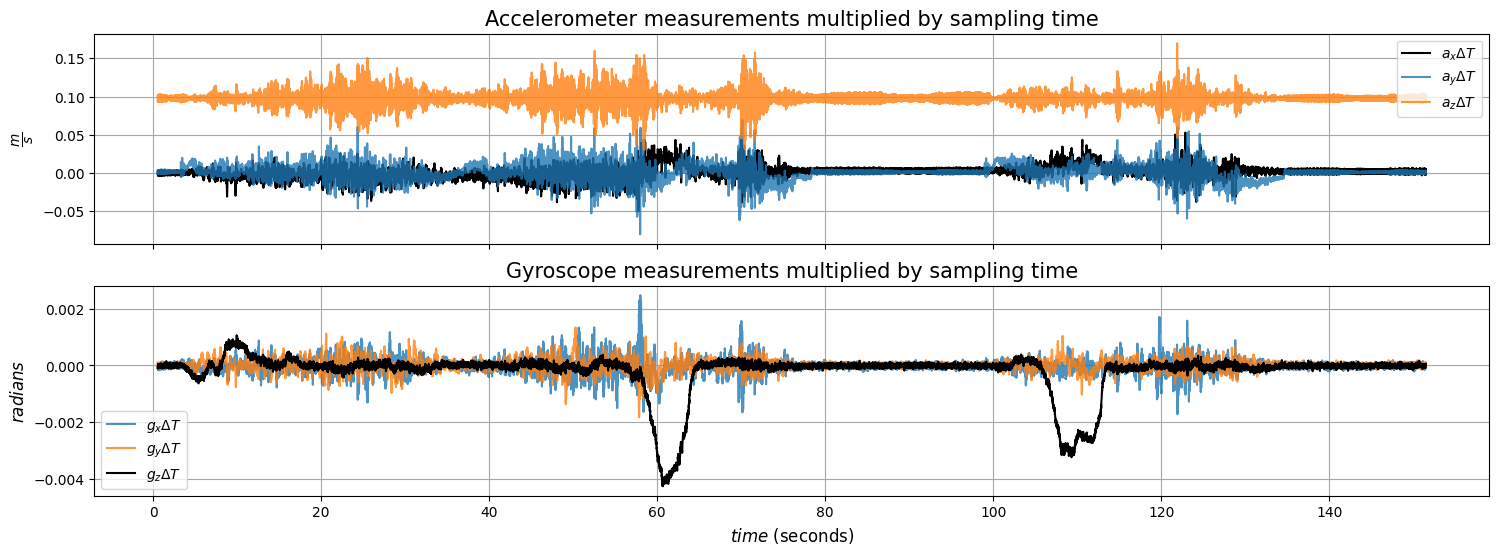

In [27]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(18,6), sharex='col')

ax1.plot(df_imu['t_rel'], df_imu['axdt'],  label=r'$a_x \Delta T$', color='k')
ax1.plot(df_imu['t_rel'], df_imu['aydt'],  label=r'$a_y \Delta T$', alpha=0.8)
ax1.plot(df_imu['t_rel'], df_imu['azdt'],  label=r'$a_z \Delta T$', alpha=0.8)


ax2.plot(df_imu['t_rel'], df_imu['gxdt'],  label=r'$g_x \Delta T$', alpha=0.8)
ax2.plot(df_imu['t_rel'], df_imu['gydt'],  label=r'$g_y \Delta T$', alpha=0.8)
ax2.plot(df_imu['t_rel'], df_imu['gzdt'],  label=r'$g_z \Delta T$', color='k')

ax1.legend()
ax1.set_title("Accelerometer measurements multiplied by sampling time", size=15)
ax1.grid(True, which='both',ls='-',color='0.65')
ax1.set_ylabel(r'$\frac{m}{s}$', size=14)

ax2.legend()
ax2.set_title("Gyroscope measurements multiplied by sampling time", size=15)
ax2.grid(True, which='both',ls='-',color='0.65')

ax2.set_xlabel(r'$time$ (seconds)', size=12)
ax2.set_ylabel(r'$radians$', size=12)   
print()

In [28]:
# Keep a copy of gnss_index, this is for later join operations
df_gnss['gnss_index'] = df_gnss.index.to_numpy()
df_gnss.head()

,time,time_sec,time_ns,ve,vn,vu,azimuth,lat,lon,alt,t_rel,gnss_index
0,1.554024e+09,1554023732,0.0,-0.036870,-0.046925,0.010547,314.263825,22.305553,114.186305,4.758984,0.0,0
1,1.554024e+09,1554023733,0.0,-0.024177,-0.057849,0.018346,314.263050,22.305552,114.186305,4.769117,1.0,1
2,1.554024e+09,1554023734,0.0,-0.015049,-0.060757,0.003461,314.262845,22.305551,114.186305,4.787987,2.0,2
3,1.554024e+09,1554023735,0.0,-0.117890,0.045884,0.008598,314.230051,22.305551,114.186305,4.819478,3.0,3
4,1.554024e+09,1554023736,0.0,-0.578752,0.536446,0.026638,314.867663,22.305553,114.186302,4.845605,4.0,4


In [29]:
_N_gnss = df_gnss.index.size
df_gnss['E'], df_gnss['N'], df_gnss['U'] = zip(*df_gnss.apply(
                                                        lambda x : pm.geodetic2enu(x['lat'], x['lon'], x['alt'],
                                                                                   df_gnss['lat'].iloc[int(_N_gnss/2)], df_gnss['lon'].iloc[int(_N_gnss/2)], df_gnss['alt'].iloc[int(_N_gnss/2)]
                                                                                   ), axis=1
))

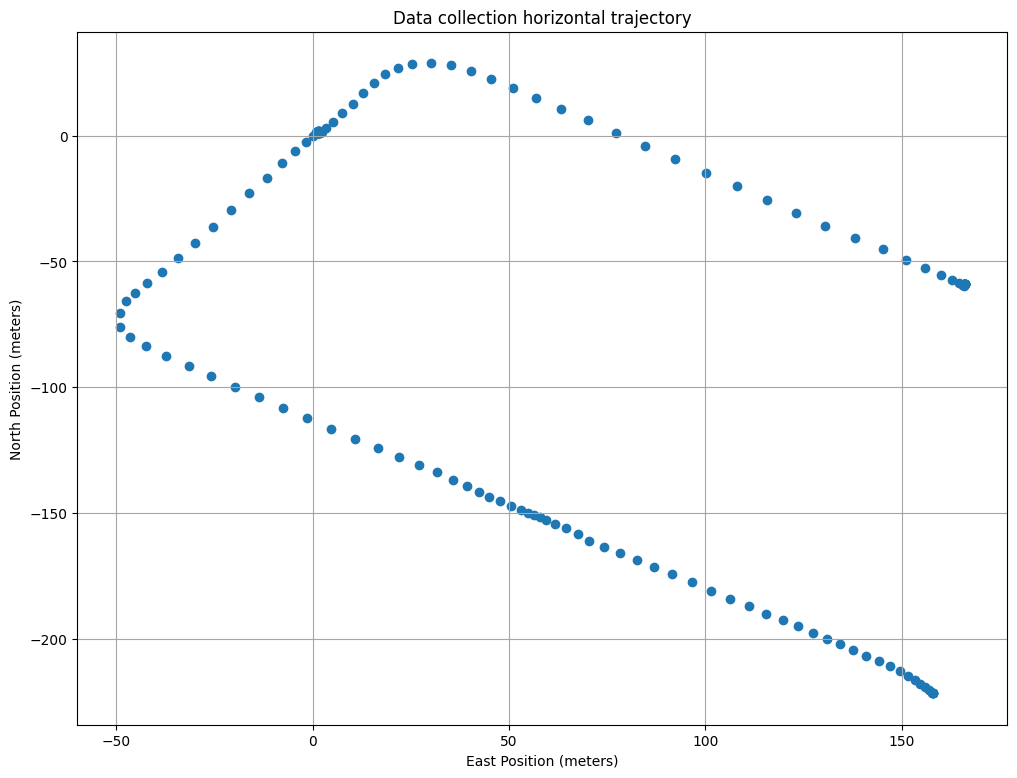

In [30]:
fig, ax = plt.subplots(figsize=(12,9))

ax.scatter(df_gnss['E'], df_gnss['N'])

ax.grid(True, which='both',ls='-',color='0.65')
ax.set_title("Data collection horizontal trajectory")
ax.set_xlabel("East Position (meters)")
ax.set_ylabel("North Position (meters)")
print()

In [31]:
# Simplify the GNSS velocity components into a single speed column which can be used for rest labeling.
# speed is in meters per seconds
df_gnss['speed'] = np.sqrt(np.square(df_gnss['ve']) + np.square(df_gnss['vn']) + np.square(df_gnss['vu']))
df_gnss.head()

,time,time_sec,time_ns,ve,vn,vu,azimuth,lat,lon,alt,t_rel,gnss_index,E,N,U,speed
0,1.554024e+09,1554023732,0.0,-0.036870,-0.046925,0.010547,314.263825,22.305553,114.186305,4.758984,0.0,0,158.041110,-221.354305,-2.793024,0.060602
1,1.554024e+09,1554023733,0.0,-0.024177,-0.057849,0.018346,314.263050,22.305552,114.186305,4.769117,1.0,1,158.083880,-221.458712,-2.782896,0.065327
2,1.554024e+09,1554023734,0.0,-0.015049,-0.060757,0.003461,314.262845,22.305551,114.186305,4.787987,2.0,2,158.075701,-221.524258,-2.764028,0.062689
3,1.554024e+09,1554023735,0.0,-0.117890,0.045884,0.008598,314.230051,22.305551,114.186305,4.819478,3.0,3,158.059610,-221.571997,-2.732539,0.126796
4,1.554024e+09,1554023736,0.0,-0.578752,0.536446,0.026638,314.867663,22.305553,114.186302,4.845605,4.0,4,157.766013,-221.306961,-2.706395,0.789580


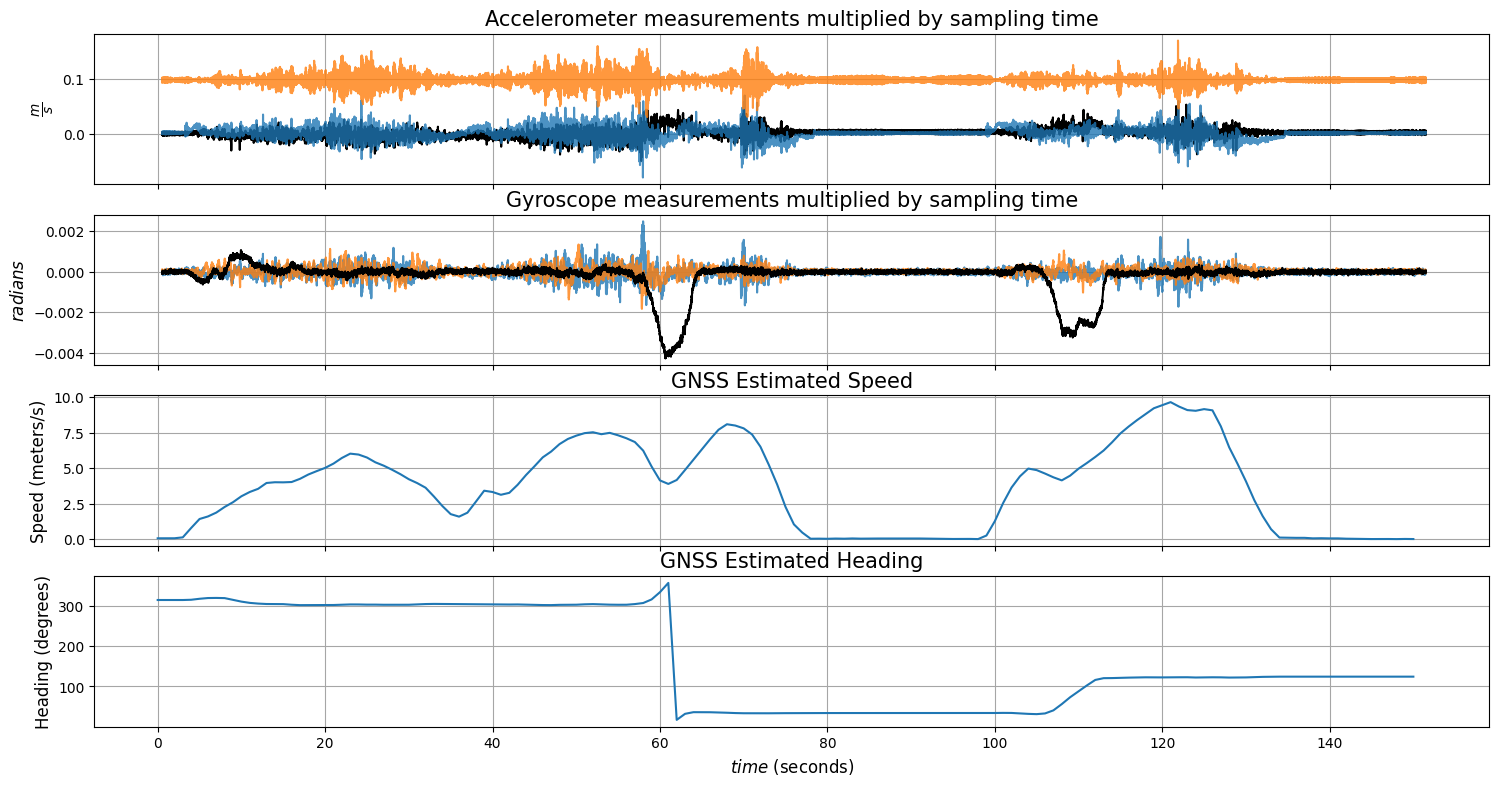

In [32]:
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(18,9),sharex='col')

axs[0].plot(df_imu['t_rel'], df_imu['axdt'],  label=r'$a_x \Delta T$', color='k')
axs[0].plot(df_imu['t_rel'], df_imu['aydt'],  label=r'$a_y \Delta T$', alpha=0.8)
axs[0].plot(df_imu['t_rel'],  df_imu['azdt'], label=r'$a_z \Delta T$', alpha=0.8)

axs[1].plot(df_imu['t_rel'], df_imu['gxdt'],  label=r'$g_x \Delta T$', alpha=0.8)
axs[1].plot(df_imu['t_rel'], df_imu['gydt'],  label=r'$g_y \Delta T$', alpha=0.8)
axs[1].plot(df_imu['t_rel'], df_imu['gzdt'],  label=r'$g_z \Delta T$', color='k')

axs[2].plot(df_gnss['t_rel'], df_gnss['speed'],  label=r'$Ve$')

axs[3].plot(df_gnss['t_rel'], df_gnss['azimuth'],  label=r'$Ve$')


axs[0].set_title("Accelerometer measurements multiplied by sampling time", size=15)
axs[0].set_ylabel(r'$\frac{m}{s}$', size=14)

axs[1].set_title("Gyroscope measurements multiplied by sampling time", size=15)
axs[1].set_ylabel(r'$radians$', size=12)   

axs[2].set_title("GNSS Estimated Speed", size=15)
axs[2].set_ylabel("Speed (meters/s)", size=12)

axs[3].set_title("GNSS Estimated Heading", size=15)
axs[3].set_ylabel("Heading (degrees)", size=12)

axs[3].set_xlabel(r'$time$ (seconds)', size=12)

print()

for ax in axs:
    ax.grid(True, which='both',ls='-',color='0.65')


Correlation between Velocity, and gyroscope, and accelerometer acitivity. Also some correlation between Azimuth and gyroscope data. Infact, accelerometer and gyroscope measure the cause of velocity changes and gyroscope measures cause of accelerometer change.

In [33]:
df_gnss['speed_next'] = df_gnss['speed'].shift(-1)
df_gnss['azimuth_next'] = df_gnss['azimuth'].shift(-1)

In [34]:
df_gnss.head()

,time,time_sec,time_ns,ve,vn,vu,azimuth,lat,lon,alt,t_rel,gnss_index,E,N,U,speed,speed_next,azimuth_next
0,1.554024e+09,1554023732,0.0,-0.036870,-0.046925,0.010547,314.263825,22.305553,114.186305,4.758984,0.0,0,158.041110,-221.354305,-2.793024,0.060602,0.065327,314.263050
1,1.554024e+09,1554023733,0.0,-0.024177,-0.057849,0.018346,314.263050,22.305552,114.186305,4.769117,1.0,1,158.083880,-221.458712,-2.782896,0.065327,0.062689,314.262845
2,1.554024e+09,1554023734,0.0,-0.015049,-0.060757,0.003461,314.262845,22.305551,114.186305,4.787987,2.0,2,158.075701,-221.524258,-2.764028,0.062689,0.126796,314.230051
3,1.554024e+09,1554023735,0.0,-0.117890,0.045884,0.008598,314.230051,22.305551,114.186305,4.819478,3.0,3,158.059610,-221.571997,-2.732539,0.126796,0.789580,314.867663
4,1.554024e+09,1554023736,0.0,-0.578752,0.536446,0.026638,314.867663,22.305553,114.186302,4.845605,4.0,4,157.766013,-221.306961,-2.706395,0.789580,1.420646,317.301767


In [35]:
df_gnss.tail(3)

,time,time_sec,time_ns,ve,vn,vu,azimuth,lat,lon,alt,t_rel,gnss_index,E,N,U,speed,speed_next,azimuth_next
148,1.554024e+09,1554023880,0.0,-0.001015,0.003429,0.002249,124.390231,22.307019,114.186383,5.619367,148.0,148,166.105744,-58.971231,-1.929260,0.004225,0.014493,124.380239
149,1.554024e+09,1554023881,0.0,-0.003084,0.006106,0.012777,124.380239,22.307019,114.186383,5.621820,149.0,149,166.099982,-58.954861,-1.926806,0.014493,0.007524,124.384350
150,1.554024e+09,1554023882,0.0,-0.002657,0.004195,-0.005653,124.384350,22.307019,114.186383,5.624374,150.0,150,166.093399,-58.938975,-1.924251,0.007524,NaN,NaN


In [36]:
df_gnss = df_gnss[df_gnss['speed_next'].notna()]

In [37]:
def classify_motion(row: pd.Series) -> tuple:
    speed = row['speed']
    speed_next = row['speed_next']

    if speed < 0.1 and speed_next < 0.1:
        return (1,0,0)
    else:
        azim = row['azimuth']
        azim_next = row['azimuth_next']
        if abs(azim - azim_next) < 2:
            return (0,1,0)
        return (0,0,1)       

In [38]:
df_gnss['rest'], df_gnss['straight'], df_gnss['turn'] = zip(*df_gnss.apply(lambda x: classify_motion(x), axis=1))

In [39]:
df_gnss.head()

,time,time_sec,time_ns,ve,vn,vu,azimuth,lat,lon,alt,...,gnss_index,E,N,U,speed,speed_next,azimuth_next,rest,straight,turn
0,1.554024e+09,1554023732,0.0,-0.036870,-0.046925,0.010547,314.263825,22.305553,114.186305,4.758984,...,0,158.041110,-221.354305,-2.793024,0.060602,0.065327,314.263050,1,0,0
1,1.554024e+09,1554023733,0.0,-0.024177,-0.057849,0.018346,314.263050,22.305552,114.186305,4.769117,...,1,158.083880,-221.458712,-2.782896,0.065327,0.062689,314.262845,1,0,0
2,1.554024e+09,1554023734,0.0,-0.015049,-0.060757,0.003461,314.262845,22.305551,114.186305,4.787987,...,2,158.075701,-221.524258,-2.764028,0.062689,0.126796,314.230051,0,1,0
3,1.554024e+09,1554023735,0.0,-0.117890,0.045884,0.008598,314.230051,22.305551,114.186305,4.819478,...,3,158.059610,-221.571997,-2.732539,0.126796,0.789580,314.867663,0,1,0
4,1.554024e+09,1554023736,0.0,-0.578752,0.536446,0.026638,314.867663,22.305553,114.186302,4.845605,...,4,157.766013,-221.306961,-2.706395,0.789580,1.420646,317.301767,0,0,1


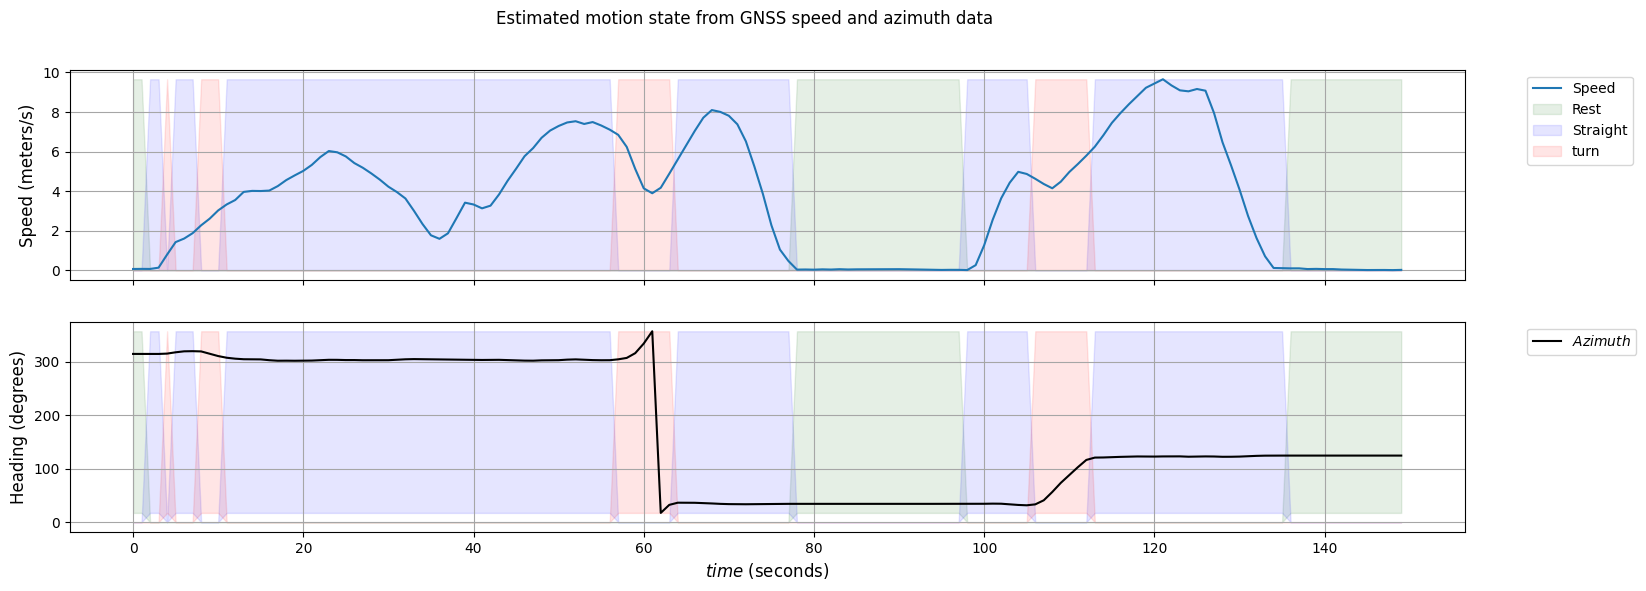

In [40]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(18,6), sharex='col')

max_spd, min_spd = max(df_gnss['speed']), min(df_gnss['speed'])
max_az, min_az = max(df_gnss['azimuth']), min(df_gnss['azimuth'])

axs[0].plot(df_gnss['t_rel'], df_gnss['speed'], label='Speed')


axs[0].fill_between(df_gnss['t_rel'], min_spd*df_gnss['rest'], max_spd*df_gnss['rest'], color='darkgreen', alpha=0.1, interpolate=True, label='Rest')
axs[0].fill_between(df_gnss['t_rel'], min_spd*df_gnss['straight'], max_spd*df_gnss['straight'], color='blue', alpha=0.1, interpolate=True,label='Straight')
axs[0].fill_between(df_gnss['t_rel'], min_spd*df_gnss['turn'], max_spd*df_gnss['turn'], color='red', alpha=0.1, label='turn')

axs[1].plot(df_gnss['t_rel'], df_gnss['azimuth'],  color='k', label=r'$Azimuth$')
axs[1].fill_between(df_gnss['t_rel'], min_az*df_gnss['rest'], max_az*df_gnss['rest'], color='darkgreen', alpha=0.1, )
axs[1].fill_between(df_gnss['t_rel'], min_az*df_gnss['straight'],max_az*df_gnss['straight'], color='blue', alpha=0.1, )
axs[1].fill_between(df_gnss['t_rel'], min_az*df_gnss['turn'], max_az*df_gnss['turn'], color='red', alpha=0.1, )

fig.suptitle("Estimated motion state from GNSS speed and azimuth data")
axs[0].set_ylabel("Speed (meters/s)", size=12)
axs[1].set_ylabel("Heading (degrees)", size=12)
axs[1].set_xlabel(r'$time$ (seconds)', size=12)

for ax in axs:
    ax.grid(True, which='both',ls='-',color='0.65')
    ax.legend(bbox_to_anchor=(1.04,1), loc='upper left')     

In [41]:
imu_gnss = pd.merge(df_imu, 
                    df_gnss,
                    how='left',
                    left_on='time_sec',
                    right_on='time_sec',
                    suffixes=['_imu', '_gnss'],)

The right side of the dataset (GNSS side) represents the last GNSS measurement right before the current IMU data

In [42]:
imu_gnss.head()

,time_imu,time_sec,time_ns_imu,gx,gy,gz,ax,ay,az,t_rel_imu,...,gnss_index,E,N,U,speed,speed_next,azimuth_next,rest,straight,turn
0,1.554024e+09,1554023732,534768104,0.005884,0.010338,-0.009073,0.234197,-0.054048,9.329669,0.534768,...,0.0,158.04111,-221.354305,-2.793024,0.060602,0.065327,314.26305,1.0,0.0,0.0
1,1.554024e+09,1554023732,544745922,0.003487,-0.005496,-0.003622,0.177139,0.337984,9.898809,0.544746,...,0.0,158.04111,-221.354305,-2.793024,0.060602,0.065327,314.26305,1.0,0.0,0.0
2,1.554024e+09,1554023732,554702043,-0.005271,0.004819,-0.001780,-0.251282,0.423911,10.246268,0.554702,...,0.0,158.04111,-221.354305,-2.793024,0.060602,0.065327,314.26305,1.0,0.0,0.0
3,1.554024e+09,1554023732,564666986,-0.002816,0.003290,-0.011617,-0.083770,0.144914,9.633576,0.564667,...,0.0,158.04111,-221.354305,-2.793024,0.060602,0.065327,314.26305,1.0,0.0,0.0
4,1.554024e+09,1554023732,574855089,0.000533,0.009487,-0.003338,0.299569,-0.024262,9.373935,0.574855,...,0.0,158.04111,-221.354305,-2.793024,0.060602,0.065327,314.26305,1.0,0.0,0.0


In [43]:
imu_gnss = imu_gnss[imu_gnss['time_ns_gnss'].notna()]
imu_gnss.head()

,time_imu,time_sec,time_ns_imu,gx,gy,gz,ax,ay,az,t_rel_imu,...,gnss_index,E,N,U,speed,speed_next,azimuth_next,rest,straight,turn
0,1.554024e+09,1554023732,534768104,0.005884,0.010338,-0.009073,0.234197,-0.054048,9.329669,0.534768,...,0.0,158.04111,-221.354305,-2.793024,0.060602,0.065327,314.26305,1.0,0.0,0.0
1,1.554024e+09,1554023732,544745922,0.003487,-0.005496,-0.003622,0.177139,0.337984,9.898809,0.544746,...,0.0,158.04111,-221.354305,-2.793024,0.060602,0.065327,314.26305,1.0,0.0,0.0
2,1.554024e+09,1554023732,554702043,-0.005271,0.004819,-0.001780,-0.251282,0.423911,10.246268,0.554702,...,0.0,158.04111,-221.354305,-2.793024,0.060602,0.065327,314.26305,1.0,0.0,0.0
3,1.554024e+09,1554023732,564666986,-0.002816,0.003290,-0.011617,-0.083770,0.144914,9.633576,0.564667,...,0.0,158.04111,-221.354305,-2.793024,0.060602,0.065327,314.26305,1.0,0.0,0.0
4,1.554024e+09,1554023732,574855089,0.000533,0.009487,-0.003338,0.299569,-0.024262,9.373935,0.574855,...,0.0,158.04111,-221.354305,-2.793024,0.060602,0.065327,314.26305,1.0,0.0,0.0


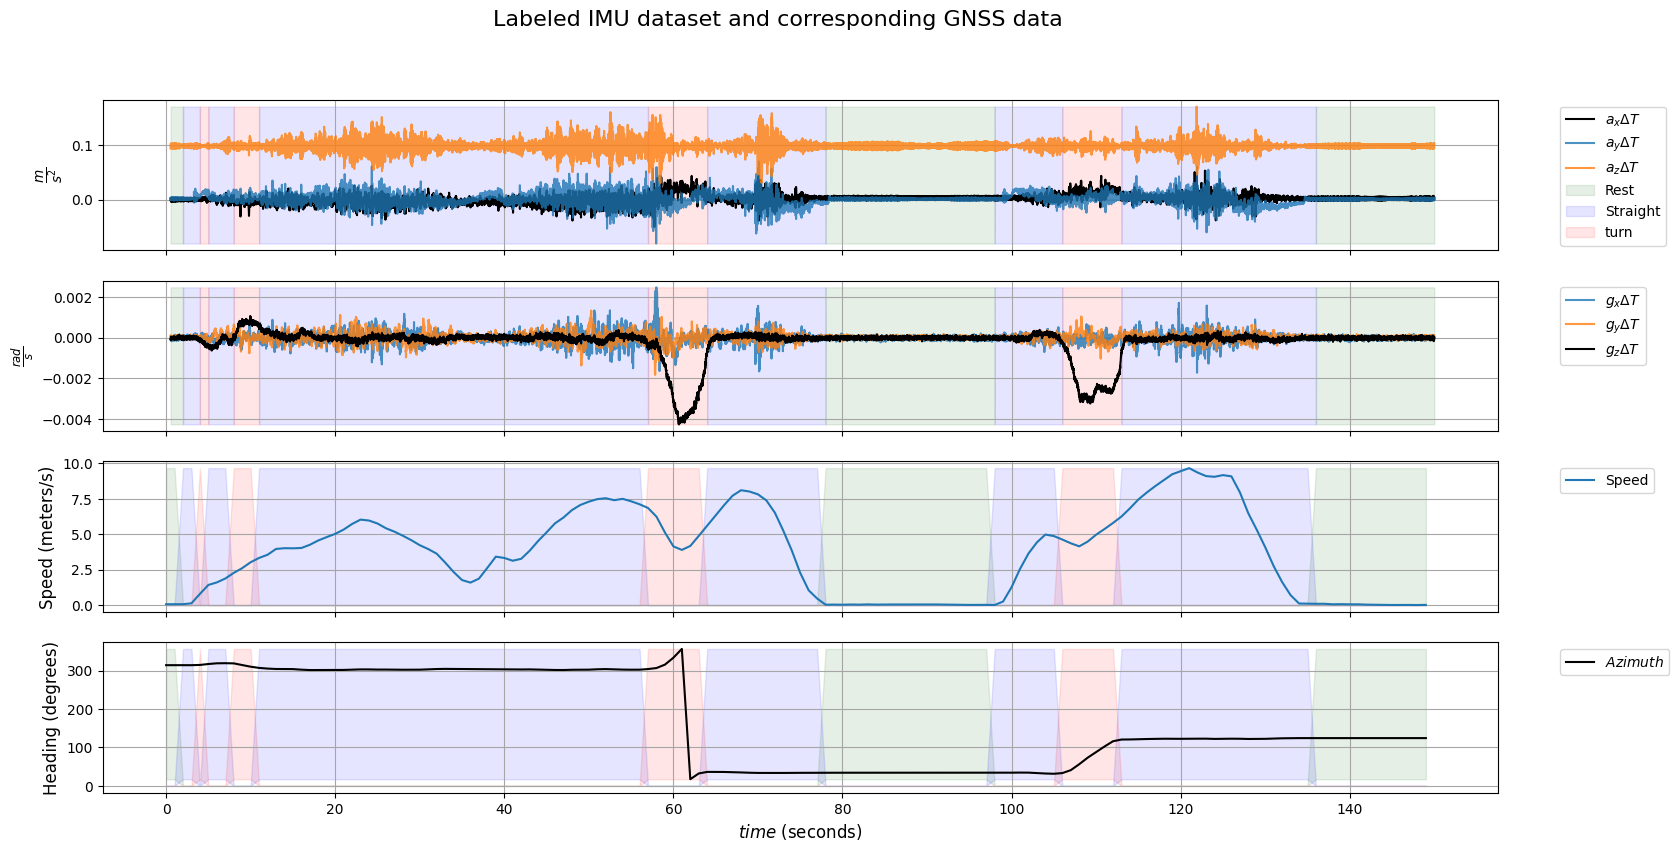

In [44]:
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(18,9), sharex='col')

a_min, a_max = min(imu_gnss['axdt'].min(), imu_gnss['aydt'].min(), imu_gnss['azdt'].min()), max(imu_gnss['axdt'].max(), imu_gnss['aydt'].max(), imu_gnss['azdt'].max())
g_min, g_max = min(imu_gnss['gxdt'].min(), imu_gnss['gydt'].min(), imu_gnss['gzdt'].min()), max(imu_gnss['gxdt'].max(), imu_gnss['gydt'].max(), imu_gnss['gzdt'].max())

axs[0].plot(imu_gnss['t_rel_imu'], imu_gnss['axdt'],  label=r'$a_x \Delta T$', color='k')
axs[0].plot(imu_gnss['t_rel_imu'],imu_gnss['aydt'],  label=r'$a_y \Delta T$', alpha=0.8)
axs[0].plot(imu_gnss['t_rel_imu'], imu_gnss['azdt'], label=r'$a_z \Delta T$', alpha=0.8)

axs[0].fill_between(imu_gnss['t_rel_imu'], a_min*imu_gnss['rest'], a_max*imu_gnss['rest'], color='darkgreen', alpha=0.1, interpolate=True, label='Rest')
axs[0].fill_between(imu_gnss['t_rel_imu'], a_min*imu_gnss['straight'], a_max*imu_gnss['straight'], color='blue', alpha=0.1, interpolate=True,label='Straight')
axs[0].fill_between(imu_gnss['t_rel_imu'], a_min*imu_gnss['turn'],  a_max*imu_gnss['turn'], color='red', alpha=0.1, label='turn')


axs[1].plot(imu_gnss['t_rel_imu'], imu_gnss['gxdt'],  label=r'$g_x \Delta T$', alpha=0.8)
axs[1].plot(imu_gnss['t_rel_imu'], imu_gnss['gydt'],  label=r'$g_y \Delta T$', alpha=0.8)
axs[1].plot(imu_gnss['t_rel_imu'], imu_gnss['gzdt'],  label=r'$g_z \Delta T$', color='k')

axs[1].fill_between(imu_gnss['t_rel_imu'], g_min*imu_gnss['rest'], g_max*imu_gnss['rest'], color='darkgreen', alpha=0.1, )
axs[1].fill_between(imu_gnss['t_rel_imu'], g_min*imu_gnss['straight' ], g_max*imu_gnss['straight'], color='blue', alpha=0.1)
axs[1].fill_between(imu_gnss['t_rel_imu'], g_min*imu_gnss['turn'],  g_max*imu_gnss['turn'], color='red', alpha=0.1)


axs[2].plot(df_gnss['t_rel'], df_gnss['speed'], label='Speed')

axs[2].fill_between(df_gnss['t_rel'], min_spd*df_gnss['rest'], max_spd*df_gnss['rest'], color='darkgreen', alpha=0.1)
axs[2].fill_between(df_gnss['t_rel'], min_spd*df_gnss['straight'], max_spd*df_gnss['straight'], color='blue', alpha=0.1)
axs[2].fill_between(df_gnss['t_rel'], min_spd*df_gnss['turn'], max_spd*df_gnss['turn'], color='red', alpha=0.1)


axs[3].plot(df_gnss['t_rel'], df_gnss['azimuth'],  color='k', label=r'$Azimuth$')
axs[3].fill_between(df_gnss['t_rel'], min_az*df_gnss['rest'], max_az*df_gnss['rest'], color='darkgreen', alpha=0.1, )
axs[3].fill_between(df_gnss['t_rel'], min_az*df_gnss['straight'],max_az*df_gnss['straight'], color='blue', alpha=0.1, )
axs[3].fill_between(df_gnss['t_rel'], min_az*df_gnss['turn'], max_az*df_gnss['turn'], color='red', alpha=0.1, )


fig.suptitle("Labeled IMU dataset and corresponding GNSS data", size=16)

axs[0].set_ylabel(r'$\frac{m}{s^2}$', size=14)
axs[1].set_ylabel(r'$\frac{rad}{s}$', size=12)

axs[2].set_ylabel("Speed (meters/s)", size=12)
axs[3].set_ylabel("Heading (degrees)", size=12)
axs[3].set_xlabel(r'$time$ (seconds)', size=12)

for ax in axs:
    ax.grid(True, which='both',ls='-',color='0.65')
    ax.legend(bbox_to_anchor=(1.04,1), loc='upper left')


In [45]:
imu_window_sum = imu_gnss.groupby(['gnss_index'])[['axdt','aydt','azdt','gxdt','gydt','gzdt','adt','gdt']].sum()
imu_window_sum.head()

,axdt,aydt,azdt,gxdt,gydt,gzdt,adt,gdt
gnss_index,,,,,,,,
0.0,0.006394,0.081056,4.600224,-0.001271,0.000601,-0.001101,4.602953,0.004064
1.0,0.017316,0.176440,9.790282,-0.001097,0.001590,-0.001171,9.795434,0.008478
2.0,0.017127,0.176695,9.788586,-0.001558,0.000661,-0.000909,9.793045,0.008932
3.0,0.032500,0.482298,9.784766,-0.000104,0.000501,-0.002057,9.808845,0.009974
4.0,0.072554,1.216363,9.795191,0.001055,0.000061,-0.027254,9.880517,0.030474


In [46]:
imu_window_var = imu_gnss.groupby(['gnss_index'])[['axdt','aydt','azdt','gxdt','gydt','gzdt','adt','gdt']].var()
imu_window_var.head()

,axdt,aydt,azdt,gxdt,gydt,gzdt,adt,gdt
gnss_index,,,,,,,,
0.0,0.000006,0.000003,0.000012,4.162347e-09,2.158534e-09,1.662997e-09,0.000012,1.818951e-09
1.0,0.000005,0.000002,0.000008,3.614823e-09,2.118414e-09,2.392751e-09,0.000008,1.380667e-09
2.0,0.000004,0.000001,0.000007,3.623142e-09,2.669124e-09,2.515259e-09,0.000007,1.120863e-09
3.0,0.000004,0.000021,0.000009,6.206409e-09,2.755071e-09,2.981368e-09,0.000009,2.348890e-09
4.0,0.000006,0.000014,0.000003,9.496197e-09,8.561489e-09,1.525361e-08,0.000003,1.464841e-08


In [47]:
imu_window_min = imu_gnss.groupby(['gnss_index'])[['axdt','aydt','azdt','gxdt','gydt','gzdt','adt','gdt']].min()
imu_window_min.head()

,axdt,aydt,azdt,gxdt,gydt,gzdt,adt,gdt
gnss_index,,,,,,,,
0.0,-0.003874,-0.001420,0.093108,-0.000179,-0.000105,-0.000116,0.093153,0.000020
1.0,-0.003610,-0.001127,0.093147,-0.000161,-0.000102,-0.000116,0.093168,0.000013
2.0,-0.003276,-0.000391,0.093406,-0.000144,-0.000107,-0.000110,0.093440,0.000033
3.0,-0.003829,-0.005365,0.092046,-0.000127,-0.000116,-0.000227,0.092092,0.000014
4.0,-0.005177,0.004268,0.093203,-0.000243,-0.000187,-0.000484,0.094830,0.000055


In [48]:
imu_window_max = imu_gnss.groupby(['gnss_index'])[['axdt','aydt','azdt','gxdt','gydt','gzdt','adt','gdt']].max()
imu_window_max.head()

,axdt,aydt,azdt,gxdt,gydt,gzdt,adt,gdt
gnss_index,,,,,,,,
0.0,0.003930,0.004634,0.102857,0.000082,0.000127,0.000083,0.102891,0.000189
1.0,0.003939,0.004913,0.102523,0.000145,0.000122,0.000154,0.102563,0.000162
2.0,0.003908,0.004152,0.102164,0.000162,0.000157,0.000116,0.102174,0.000179
3.0,0.004668,0.020014,0.102909,0.000229,0.000139,0.000106,0.103117,0.000243
4.0,0.005518,0.019253,0.102949,0.000252,0.000201,-0.000023,0.103888,0.000521


In [47]:
df_gnss.head()

,time,time_sec,time_ns,ve,vn,vu,azimuth,lat,lon,alt,...,gnss_index,E,N,U,speed,speed_next,azimuth_next,rest,straight,turn
0,1.554024e+09,1554023732,0.0,-0.036870,-0.046925,0.010547,314.263825,22.305553,114.186305,4.758984,...,0,158.041110,-221.354305,-2.793024,0.060602,0.065327,314.263050,1,0,0
1,1.554024e+09,1554023733,0.0,-0.024177,-0.057849,0.018346,314.263050,22.305552,114.186305,4.769117,...,1,158.083880,-221.458712,-2.782896,0.065327,0.062689,314.262845,1,0,0
2,1.554024e+09,1554023734,0.0,-0.015049,-0.060757,0.003461,314.262845,22.305551,114.186305,4.787987,...,2,158.075701,-221.524258,-2.764028,0.062689,0.126796,314.230051,0,1,0
3,1.554024e+09,1554023735,0.0,-0.117890,0.045884,0.008598,314.230051,22.305551,114.186305,4.819478,...,3,158.059610,-221.571997,-2.732539,0.126796,0.789580,314.867663,0,1,0
4,1.554024e+09,1554023736,0.0,-0.578752,0.536446,0.026638,314.867663,22.305553,114.186302,4.845605,...,4,157.766013,-221.306961,-2.706395,0.789580,1.420646,317.301767,0,0,1


In [49]:
df_labels = df_gnss[['gnss_index', 'rest', 'straight','turn']].copy()
df_labels.head()

,gnss_index,rest,straight,turn
0,0,1,0,0
1,1,1,0,0
2,2,0,1,0
3,3,0,1,0
4,4,0,0,1


In [50]:
# Add the features to the labels dataset
res_to_sffx = {
        '_sum': imu_window_sum,
        '_var': imu_window_var,
        '_min': imu_window_min,
        '_max': imu_window_max,
}
for key, _df in res_to_sffx.items():
    df_labels = pd.merge(
                left=df_labels,
                right=_df,
                left_on ='gnss_index',
                right_on='gnss_index',
                suffixes=[None, key]
    )

In [51]:
df_labels.head()

,gnss_index,rest,straight,turn,axdt,aydt,azdt,gxdt,gydt,gzdt,...,adt_min,gdt_min,axdt_max,aydt_max,azdt_max,gxdt_max,gydt_max,gzdt_max,adt_max,gdt_max
0,0,1,0,0,0.006394,0.081056,4.600224,-0.001271,0.000601,-0.001101,...,0.093153,0.000020,0.003930,0.004634,0.102857,0.000082,0.000127,0.000083,0.102891,0.000189
1,1,1,0,0,0.017316,0.176440,9.790282,-0.001097,0.001590,-0.001171,...,0.093168,0.000013,0.003939,0.004913,0.102523,0.000145,0.000122,0.000154,0.102563,0.000162
2,2,0,1,0,0.017127,0.176695,9.788586,-0.001558,0.000661,-0.000909,...,0.093440,0.000033,0.003908,0.004152,0.102164,0.000162,0.000157,0.000116,0.102174,0.000179
3,3,0,1,0,0.032500,0.482298,9.784766,-0.000104,0.000501,-0.002057,...,0.092092,0.000014,0.004668,0.020014,0.102909,0.000229,0.000139,0.000106,0.103117,0.000243
4,4,0,0,1,0.072554,1.216363,9.795191,0.001055,0.000061,-0.027254,...,0.094830,0.000055,0.005518,0.019253,0.102949,0.000252,0.000201,-0.000023,0.103888,0.000521


In [51]:
df_labels['gnss_index_start'] = df_labels['gnss_index'].copy()
df_labels['gnss_index_end'] = df_labels['gnss_index_start'] + 1

In [52]:
df_labels.head()

,gnss_index,rest,straight,turn,axdt,aydt,azdt,gxdt,gydt,gzdt,...,adt_min,gdt_min,axdt_max,aydt_max,azdt_max,gxdt_max,gydt_max,gzdt_max,adt_max,gdt_max
0,0,1,0,0,0.006394,0.081056,4.600224,-0.001271,0.000601,-0.001101,...,0.093153,0.000020,0.003930,0.004634,0.102857,0.000082,0.000127,0.000083,0.102891,0.000189
1,1,1,0,0,0.017316,0.176440,9.790282,-0.001097,0.001590,-0.001171,...,0.093168,0.000013,0.003939,0.004913,0.102523,0.000145,0.000122,0.000154,0.102563,0.000162
2,2,0,1,0,0.017127,0.176695,9.788586,-0.001558,0.000661,-0.000909,...,0.093440,0.000033,0.003908,0.004152,0.102164,0.000162,0.000157,0.000116,0.102174,0.000179
3,3,0,1,0,0.032500,0.482298,9.784766,-0.000104,0.000501,-0.002057,...,0.092092,0.000014,0.004668,0.020014,0.102909,0.000229,0.000139,0.000106,0.103117,0.000243
4,4,0,0,1,0.072554,1.216363,9.795191,0.001055,0.000061,-0.027254,...,0.094830,0.000055,0.005518,0.019253,0.102949,0.000252,0.000201,-0.000023,0.103888,0.000521


In [53]:
rename_map = {}
for col in ['ax', 'ay', 'az', 'gx', 'gy', 'gz', 'a', 'g']:
    rename_map[col+'dt'] = col+'dt_sum'
df_results = df_labels.rename(rename_map, axis=1).copy()
df_results.head()

,gnss_index,rest,straight,turn,axdt_sum,aydt_sum,azdt_sum,gxdt_sum,gydt_sum,gzdt_sum,...,adt_min,gdt_min,axdt_max,aydt_max,azdt_max,gxdt_max,gydt_max,gzdt_max,adt_max,gdt_max
0,0,1,0,0,0.006394,0.081056,4.600224,-0.001271,0.000601,-0.001101,...,0.093153,0.000020,0.003930,0.004634,0.102857,0.000082,0.000127,0.000083,0.102891,0.000189
1,1,1,0,0,0.017316,0.176440,9.790282,-0.001097,0.001590,-0.001171,...,0.093168,0.000013,0.003939,0.004913,0.102523,0.000145,0.000122,0.000154,0.102563,0.000162
2,2,0,1,0,0.017127,0.176695,9.788586,-0.001558,0.000661,-0.000909,...,0.093440,0.000033,0.003908,0.004152,0.102164,0.000162,0.000157,0.000116,0.102174,0.000179
3,3,0,1,0,0.032500,0.482298,9.784766,-0.000104,0.000501,-0.002057,...,0.092092,0.000014,0.004668,0.020014,0.102909,0.000229,0.000139,0.000106,0.103117,0.000243
4,4,0,0,1,0.072554,1.216363,9.795191,0.001055,0.000061,-0.027254,...,0.094830,0.000055,0.005518,0.019253,0.102949,0.000252,0.000201,-0.000023,0.103888,0.000521


In [54]:
def motion_state_str(row: pd.Series) -> str:
    if row['rest']:
        return 'rest'
    if row['straight']:
        return 'straight'
    if row['turn']:
        return 'turn'
df_results['motion_state'] = df_results.apply(lambda x: motion_state_str(x), axis=1)

In [55]:
feature_target_cols = 'motion_state,adt_sum,gdt_sum,axdt_var,aydt_var,azdt_var,gxdt_var,gydt_var,gzdt_var,adt_var,gdt_var,adt_min,gdt_min,adt_max,gdt_max'.split(',')
feature_target_cols 

['motion_state',
 'adt_sum',
 'gdt_sum',
 'axdt_var',
 'aydt_var',
 'azdt_var',
 'gxdt_var',
 'gydt_var',
 'gzdt_var',
 'adt_var',
 'gdt_var',
 'adt_min',
 'gdt_min',
 'adt_max',
 'gdt_max']

In [56]:
df_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 37 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   gnss_index    150 non-null    int64  
 1   rest          150 non-null    int64  
 2   straight      150 non-null    int64  
 3   turn          150 non-null    int64  
 4   axdt_sum      150 non-null    float64
 5   aydt_sum      150 non-null    float64
 6   azdt_sum      150 non-null    float64
 7   gxdt_sum      150 non-null    float64
 8   gydt_sum      150 non-null    float64
 9   gzdt_sum      150 non-null    float64
 10  adt_sum       150 non-null    float64
 11  gdt_sum       150 non-null    float64
 12  axdt_var      150 non-null    float64
 13  aydt_var      150 non-null    float64
 14  azdt_var      150 non-null    float64
 15  gxdt_var      150 non-null    float64
 16  gydt_var      150 non-null    float64
 17  gzdt_var      150 non-null    float64
 18  adt_var       150 non-null    

In [57]:
df_results[feature_target_cols].to_csv('data/testing.csv', index=False)